In [1]:
pip install vaderSentiment

In [1]:
import csv
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import json
from transformers import pipeline


C:\Users\bhavp\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
classifier = pipeline("zero-shot-classification")

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [3]:
def analyze_sentiment(comment):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(comment)
    compound_score = vs['compound']
    
    if compound_score >= 0.5:
        return 'Very Positive'
    elif 0.1 <= compound_score < 0.5:
        return 'Positive'
    elif -0.1 <= compound_score < 0.1:
        return 'Neutral'
    elif -0.5 <= compound_score < -0.1:
        return 'Negative'
    elif compound_score < -0.5:
        return 'Very Negative'


In [4]:
def label_topic(post):
    topics = ["Healthcare", "Education", "Economy", "Trade", "Poverty", "Energy",
              "Climate Change", "Environment", "Sustainability", "Water", "Food Security",
              "Human Rights", "War and Conflict", "Peacekeeping", "Security", "Cybersecurity",
              "Diplomacy", "Foreign Policy", "International Relations", "Global Governance",
              "Development", "Humanitarian Aid", "Migration", "Refugees", "Demographics",
              "Globalization", "Technology", "Innovation", "Artificial Intelligence",
              "Space Exploration", "Oceans", "Arctic", "Antarctica", "Disarmament",
              "Nuclear Weapons", "Non-Proliferation", "Chemical Weapons", "Biological Weapons",
              "Public Health", "Pandemics", "HIV/AIDS", "Malaria", "Tuberculosis",
              "Mental Health", "Maternal Health", "Child Health", "Non-Communicable Diseases",
              "Universal Health Coverage", "United Nations", "World Health Organization",
              "World Trade Organization", "International Monetary Fund", "World Bank",
              "G20", "BRICS", "NATO", "European Union", "African Union", "Arab League",
              "Association of Southeast Asian Nations", "Organization of American States",
              "Xi Jinping", "Joe Biden", "Donald Trump", "Vladimir Putin", "Narendra Modi",
              "Angela Merkel", "Emmanuel Macron", "Boris Johnson", "Jair Bolsonaro"]
    result = classifier(post['Title'], topics)
    return [result['labels'][0]]

In [5]:
with open('data.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

total_comments = 0
overall_sentiments = {'Very Positive': 0, 'Positive': 0, 'Neutral': 0, 'Negative': 0, 'Very Negative': 0}
tag_counter = Counter()
tag_sentiments = {}

In [6]:
with open('sentiment_analysis_Vader.csv', mode='w', newline='') as file:
    fieldnames = ['Post Number', 'Comment Count', 'Very Positive', 'Positive', 'Neutral', 'Negative', 'Very Negative', 'Topics']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for i, post in enumerate(data):
        sentiments = {'Very Positive': 0, 'Positive': 0, 'Neutral': 0, 'Negative': 0, 'Very Negative': 0}
        comments = post['Comments']
        for comment in comments:
            sentiment = analyze_sentiment(comment)
            sentiments[sentiment] += 1
            overall_sentiments[sentiment] += 1
        total_comments += len(comments)
        topics = label_topic(post)
        for topic in topics:
            tag_counter.update([topic])
            if topic not in tag_sentiments:
                tag_sentiments[topic] = {'Very Positive': 0, 'Positive': 0, 'Neutral': 0, 'Negative': 0, 'Very Negative': 0}
            tag_sentiments[topic][sentiment] += 1

        writer.writerow({
            'Post Number': i + 1,
            'Comment Count': len(comments),
            'Very Positive': sentiments['Very Positive'],
            'Positive': sentiments['Positive'],
            'Neutral': sentiments['Neutral'],
            'Negative': sentiments['Negative'],
            'Very Negative': sentiments['Very Negative'],
            'Topics': topics[0] if topics else ''
        })

    writer.writerow({
        'Post Number': 'Total',
        'Comment Count': total_comments,
        'Very Positive': overall_sentiments['Very Positive'],
        'Positive': overall_sentiments['Positive'],
        'Neutral': overall_sentiments['Neutral'],
        'Negative': overall_sentiments['Negative'],
        'Very Negative': overall_sentiments['Very Negative'],
        'Topics': ''
    })

print("Sentiment analysis results saved to 'sentiment_analysis_results.csv'")

Sentiment analysis results saved to 'sentiment_analysis_results.csv'


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:

data = pd.read_csv('sentiment_analysis_Vader.csv')
data.head()

,Post Number,Comment Count,Very Positive,Positive,Neutral,Negative,Very Negative,Topics
0,1,70,12,12,24,6,16,Joe Biden
1,2,78,16,12,35,9,6,Demographics
2,3,81,13,17,20,12,19,Donald Trump
3,4,86,14,20,36,6,10,Donald Trump
4,5,74,12,12,25,11,14,Joe Biden


In [12]:
data = data.iloc[:-1]

<Figure size 1400x800 with 0 Axes>

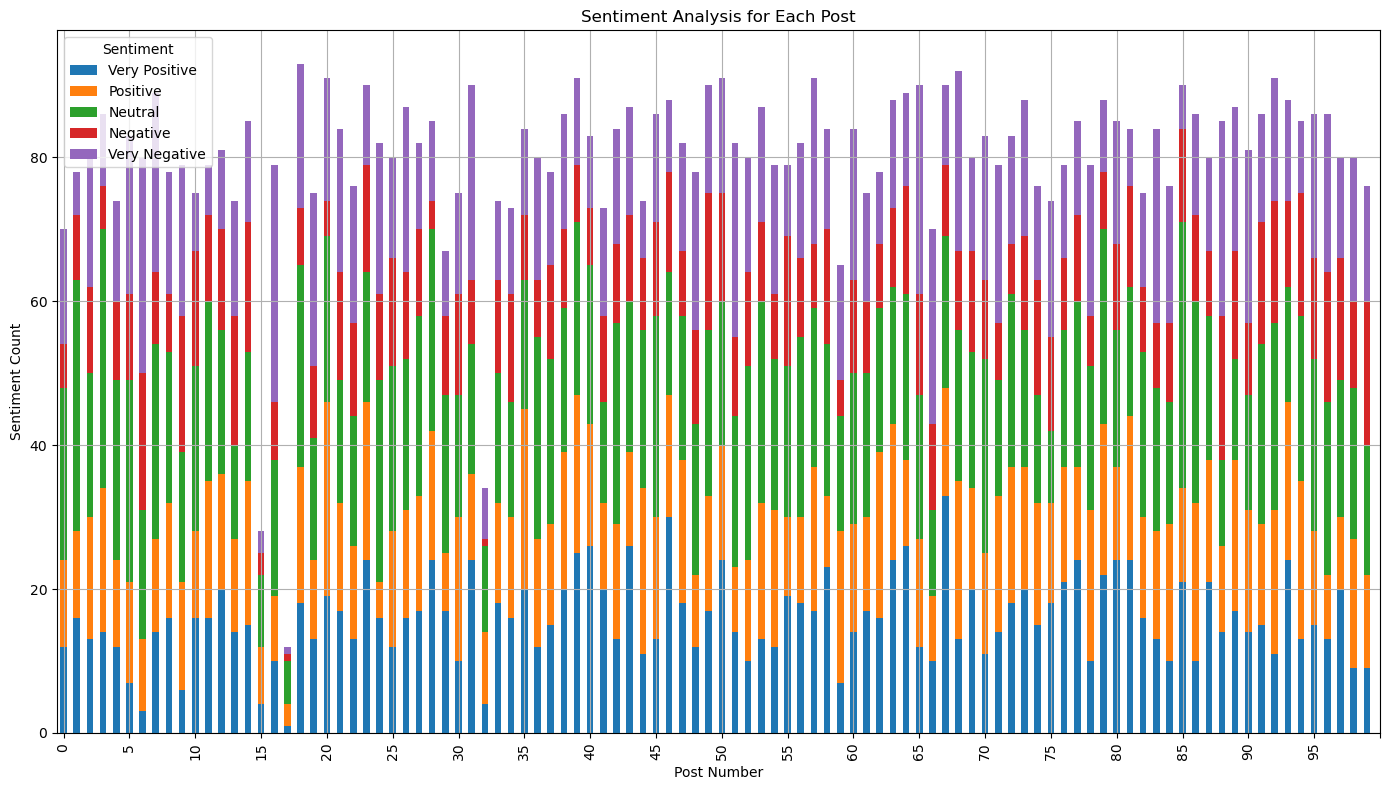

In [13]:
# Selecting the relevant columns
data = data[['Very Positive', 'Positive', 'Neutral', 'Negative', 'Very Negative']]

# Plotting
plt.figure(figsize=(14, 8))
data.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Sentiment Analysis for Each Post')
plt.xlabel('Post Number')
plt.ylabel('Sentiment Count')
plt.legend(title='Sentiment')
plt.grid(True)
plt.xticks(range(0, 101, 5))  # Adjust the ticks based on your data
plt.tight_layout()
plt.show()